In [1]:
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List
import matplotlib.pyplot as plt

## 2.7 Neural Networks from Scratch
We’ve just seen how to build and train a linear regression model from first principles. How can we extend this chain of reasoning to design a more complex model that can learn nonlinear relationships? The central idea is that we’ll first do many linear regressions, then feed the results through a nonlinear function, and finally do one last linear regression that ultimately makes the predictions. As it will turn out, we can reason through how to compute the gradients for this more complicated model in the same way we did for the linear regression model.

### Step 1: A Bunch of Linear Regressions
What does it mean to do “a bunch of linear regressions”? Well, doing one linear regression involved doing a matrix multiplication with a set of parameters: if our data $X$ had dimensions `[batch_size, num_features]`, then we multiplied it by a weight matrix $W$ with dimensions `[num_features, 1]` to get an output of dimension `[batch_size, 1]`; this output is, for each observation in the batch, simply a weighted sum of the original features. To do multiple linear regressions, we’ll simply multiply our input by a weight matrix with dimensions `[num_features, num_outputs]`, resulting in an output of dimensions `[batch_size, num_outputs]`; now, for each observation, we have `num_outputs` different weighted sums of the original features.

What are these weighted sums? We should think of each of them as a “learned feature”—a combination of the original features that, once the network is trained, will represent its attempt to learn combinations of features that help it accurately predict house prices. How many learned features should we create? Let’s create $13$ of them, since we created $13$ original features.

### Step 2: A Nonlinear Function
Next, we’ll feed each of these weighted sums through a nonlinear function; the first function we’ll try is the sigmoid function that was mentioned in `Chapter 1`. 

Why is using this nonlinear function a good idea? Why not the square function $f(x) = x^2$, for example? There are a couple of reasons:
+ First, we want the function we use here to be monotonic so that it “preserves” information about the numbers that were fed in. Let’s say that, given the date that was fed in, two of our linear regressions produced values of $–3$ and $3$, respectively. Feeding these through the square function would then produce a value of $9$ for each, so that any function that receives these numbers as inputs after they were fed through the square function would “lose” the information that one of them was originally $–3$ and the other was $3$.

+ Second, the function is nonlinear; this nonlinearity will enable our neural network to model the inherently nonlinear relationship between the features and the target.

+ Finally, the sigmoid function has the nice property that its derivative can be expressed in terms of the function itself: $\displaystyle\frac{\partial\sigma}{\partial u}=\sigma(x)\times(1-\sigma(x))$.

### Step 3: Another Linear Regression
Finally, we’ll take the resulting $13$ elements—each of which is a combination of the original features, fed through the sigmoid function so that they all have values between $0$ and $1$—and feed them into a regular linear regression, using them the same way we used our original features previously.

<img src="images/02_10.png" style="width:600px;"/>

You’ll see that we start with matrix multiplication and matrix addition, as before. Now let’s formalize some terminology that was mentioned previously: when we apply these operations in the course of a nested function, we’ll call the first matrix that we use to transform the input features the weight matrix, and we’ll call the second matrix, the one that is added to each resulting set of features, the bias. That’s why we’ll denote these as $W_1$ and $B_1$.

After applying these operations, we’ll feed the results through a sigmoid function and then repeat the process again with another set of weights and biases—now called $W_2$ and $B_2$ —to get our final prediction, $P$.

##### Another diagram?
Does representing things in terms of these individual steps give you intuition for what is going on? This question gets at a key theme of this book: to fully understand neural networks, we have to see multiple representations, each one of which highlights a different aspect of how neural networks work. The representation in `Figure 2-10` doesn’t give much intuition about the “structure” of the network, but it does indicate clearly how to train such a model: on the backward pass, we’ll compute the partial derivative of each constituent function, evaluated at the input to that function, and then calculate the gradients of the loss with respect to each of the weights by simply multiplying all of these derivatives together—just as we saw in the simple chain rule examples from `Chapter 1`.

In [2]:
# Initialize weights during the forward pass for step-by-step neural network model.
def init_weights(input_size: int, hidden_size: int) -> Dict[str, ndarray]:
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

# Compute the forward pass and the loss for the step-by-step neural network model.
def forward_loss(X: ndarray, y: ndarray, 
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    M1 = np.dot(X, weights['W1'])
    N1 = M1 + weights['B1']
    O1 = sigmoid(N1)
    M2 = np.dot(O1, weights['W2'])
    P = M2 + weights['B2']    
    loss = np.mean(np.power(y - P, 2))
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y
    return forward_info, loss

### Neural Networks: The Backward Pass
The backward pass works the same way as in the simpler linear regression model from earlier in the chapter, just with more steps.

The steps, as a reminder, are:
1. Compute the derivative of each operation and evaluate it at its input.
2. Multiply the results together.

<img src="images/02_12.png" style="width:600px;"/>

<img src="images/t_02_01.png" style="width:600px;"/>

The `loss_gradients` function computes each of the partial derivatives in `Table 2-1` and multiplies them together to get the gradients of the loss with respect to each of the ndarrays containing the weights:
+ dLdW2
+ dLdB2
+ dLdW1
+ dLdB1

The only caveat is that we sum the expressions we compute for `dLdB1` and `dLdB2` along `axis = 0`, as described in “Gradient of the Loss with Respect to the Bias Terms” on `page 225`.

In [3]:
# Compute the partial derivatives of the loss with respect to each of the parameters in the neural network.
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:   
    dLdP = -(forward_info['y'] - forward_info['P'])  
    dPdM2 = np.ones_like(forward_info['M2'])
    dLdM2 = dLdP * dPdM2
    dPdB2 = np.ones_like(weights['B2'])
    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    dLdW2 = np.dot(dM2dW2, dLdP)
    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 
    dLdO1 = np.dot(dLdM2, dM2dO1)
    dO1dN1 = sigmoid(forward_info['N1']) * (1- sigmoid(forward_info['N1']))
    dLdN1 = dLdO1 * dO1dN1
    dN1dB1 = np.ones_like(weights['B1'])
    dN1dM1 = np.ones_like(forward_info['M1'])
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    dLdM1 = dLdN1 * dN1dM1
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 
    dLdW1 = np.dot(dM1dW1, dLdM1)
    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    return loss_gradients

We’ve finally built our first neural network from scratch! Let’s see if it is in fact any better than our linear regression model.

In [4]:
def mae(preds: ndarray, actuals: ndarray):
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

# 
# Permute X and y, using the same permutation, along axis=0
def permute_data(X: ndarray, y: ndarray):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

# 
# Generate batch from X and y, given a start position
def generate_batch(X: ndarray, y: ndarray, 
                   start: int=0, batch_size: int=10) -> Tuple[ndarray, ndarray]:
    assert X.ndim == y.ndim == 2, "X and Y must be 2 dimensional"
    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    return X_batch, y_batch

#
# Generate predictions from the step-by-step neural network model.
def predict(X: ndarray, weights: Dict[str, ndarray]) -> ndarray:
    M1 = np.dot(X, weights['W1'])
    N1 = M1 + weights['B1']
    O1 = sigmoid(N1)
    M2 = np.dot(O1, weights['W2'])
    P = M2 + weights['B2']    
    return P

In [5]:
def train(X_train: ndarray, y_train: ndarray, X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:
    if seed:
        np.random.seed(seed)
    start = 0
    # Initialize weights
    weights = init_weights(X_train.shape[1], hidden_size=hidden_size)
    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    losses = []
    val_scores = []
    for i in range(n_iter):
        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)
        if return_losses:
            losses.append(loss)
        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))
    if return_weights:
        return losses, weights, val_scores
    return None

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

s = StandardScaler()
data = s.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [7]:
num_iter = 10000
test_every = 1000
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=num_iter,
                   test_every = test_every,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
losses = train_info[0]
weights = train_info[1]
val_scores = train_info[2]

In [8]:
preds = predict(X_test, weights)

In [9]:
"Mean absolute error: {mae}".format(mae=round(mae(preds, y_test), 4))

'Mean absolute error: 2.7111'

In [10]:
"Root mean squared error: {rmse}".format(rmse=round(rmse(preds, y_test), 4))

'Root mean squared error: 3.8133'

Both values are significantly lower than the prior model! Looking at the plot of predictions versus actuals in `Figure 2-13` shows similar improvements.

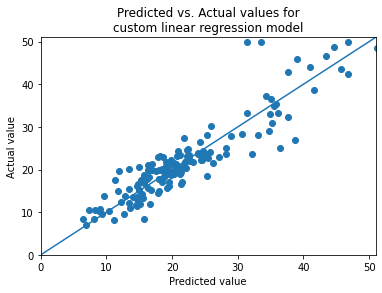

In [11]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

### Two Reasons Why This Is Happening
Why does this model appear to be performing better than the model before? Recall that there was a nonlinear relationship between the most important feature of our earlier model and our target; nevertheless, our model was constrained to learn only linear relationships between individual features and our target. I claim that, by adding a nonlinear function into the mix, we have allowed our model to learn the proper, nonlinear relationship between our features and our target.

Let’s visualize this. `Figure 2-14` shows the same plot we showed in the linear regression section, plotting the normalized values of the most important feature from our model along with both the values of the target and the predictions that would result from feeding the mean values of the other features while varying the values of the most important feature from $–3.5$ to $1.5$, as before.

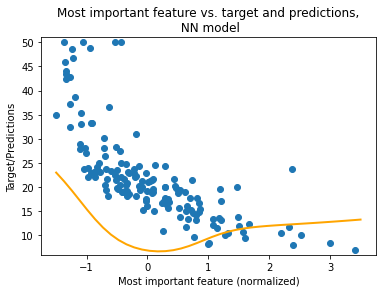

In [12]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n NN model");

We can see that the relationship shown (a) is now nonlinear and (b) more closely matches the relationship between this feature and the target (represented by the points), as desired. So adding the nonlinear function to our model allowed it to learn, via iteratively updating the weights using the training, the nonlinear relationship that existed between the inputs and the outputs.